# Overview

This notebook is used to demonstrate how to use the module `neutronimaging` to perform correction for data collected with the MCP detector.

In [1]:
# prep env
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

In [2]:
# try to import necessary functions
from neutronimaging.detector_correction import read_shutter_count
from neutronimaging.detector_correction import read_shutter_time
from neutronimaging.detector_correction import read_spectra
from neutronimaging.detector_correction import merge_meta_data
from neutronimaging.detector_correction import load_images
from neutronimaging.detector_correction import calc_pixel_occupancy_probability
from neutronimaging.detector_correction import correct_images

In [3]:
shutter_count_file = "../data/OB_1_005_ShutterCount.txt"
df_shutter_count = read_shutter_count(shutter_count_file)
df_shutter_count

,shutter_index,shutter_counts,shutter_n_ratio
0,0,194873,1.000000
1,1,195956,1.005557
2,2,204702,1.050438
3,3,206068,1.057448


In [4]:
shutter_time_file = "../data/OB_1_005_ShutterTimes.txt"
df_shutter_time = read_shutter_time(shutter_time_file)
df_shutter_time

,shutter_index,start_frame,end_frame
0,0,0.000459,0.001760
1,1,0.002081,0.005204
2,2,0.005521,0.007702
3,3,0.008022,0.010797


In [5]:
spectra_file = "../data/OB_1_005_Spectra.txt"
df_spectra = read_spectra(spectra_file)
df_spectra

,shutter_time,counts
0,0.000459,162259
1,0.000469,160845
2,0.000480,161957
3,0.000490,162464
4,0.000500,161892
...,...,...
911,0.010746,21629055
912,0.010756,21620221
913,0.010766,21593506
914,0.010776,21587283


In [6]:
# merge into one metadata dataframe
df_meta = merge_meta_data(df_shutter_count, df_shutter_time, df_spectra)
df_meta

,shutter_time,counts,run_num,shutter_index,shutter_counts,shutter_n_ratio
0,0.000459,162259,0,0,194873,1.000000
1,0.000469,160845,1,0,194873,1.000000
2,0.000480,161957,2,0,194873,1.000000
3,0.000490,162464,3,0,194873,1.000000
4,0.000500,161892,4,0,194873,1.000000
...,...,...,...,...,...,...
911,0.010746,21629055,911,3,206068,1.057448
912,0.010756,21620221,912,3,206068,1.057448
913,0.010766,21593506,913,3,206068,1.057448
914,0.010776,21587283,914,3,206068,1.057448


In [7]:
# loading testing images
img_dir = "../data/"
o_norm = load_images(img_dir)
print(type(o_norm))

<class 'NeuNorm.normalization.Normalization'>


In [8]:
# [optional] calculate the pixel occupancy probability
pop = calc_pixel_occupancy_probability(o_norm, df_meta)
print(type(pop), pop.shape)

<class 'numpy.ndarray'> (916, 512, 512)


<IPython.core.display.Javascript object>


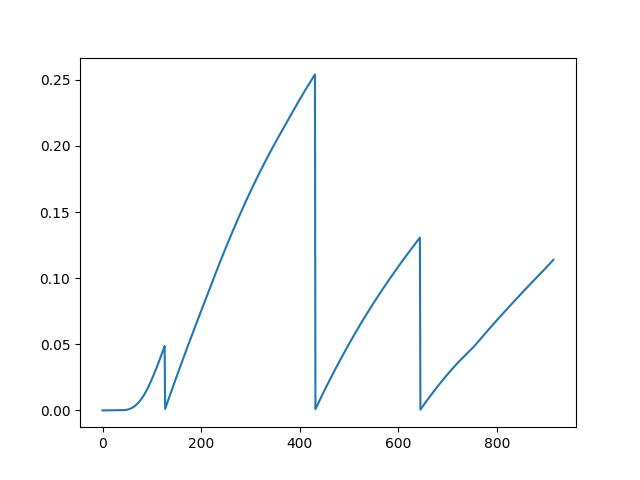

In [9]:
prof = [np.mean(img) for img in pop]
plt.figure()
plt.plot(prof)
np.savez('ref_pop_prof', prof)

In [10]:
# perform the image correction
imgs = correct_images(o_norm, df_meta)
print(type(imgs), imgs.shape, imgs.dtype)

<class 'numpy.ndarray'> (916, 512, 512) float64


In [11]:
# perform the image correction
imgs_skip_first_and_last = correct_images(o_norm, df_meta, skip_first_and_last=True)
print(type(imgs_skip_first_and_last), imgs_skip_first_and_last.shape, imgs_skip_first_and_last.dtype)

<class 'numpy.ndarray'> (908, 512, 512) float64


# Checking raw and corrected data

In [12]:
imgs_raw = np.array(o_norm.data['sample']['data'])
print(imgs_raw.shape, imgs_raw.dtype)

(916, 512, 512) float32


In [13]:
@interact(n=(0,915))
def compare(n):
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(imgs_raw[n,:,:], cmap="Greys")
    ax[0].set_title("raw")
    ax[1].imshow(imgs[n,:,:], cmap="Greys")
    ax[1].set_title("corrected")

interactive(children=(IntSlider(value=457, description='n', max=915), Output()), _dom_classes=('widget-interac…

<IPython.core.display.Javascript object>


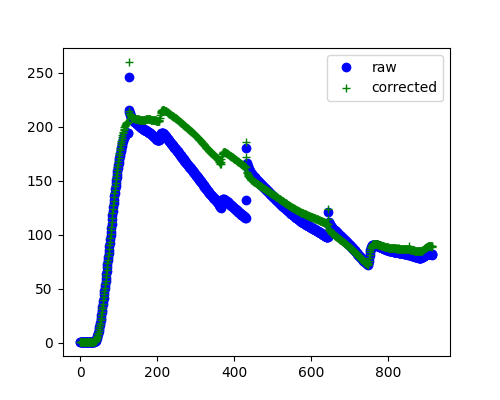

In [14]:
fig, ax = plt.subplots(figsize=(5, 4))

prof_raw = [np.mean(img) for img in imgs_raw]
prof_new = [np.mean(img) for img in imgs]

ax.plot(prof_raw, "bo", label="raw")
ax.plot(prof_new, "g+", label="corrected")

ax.legend()

In [15]:
np.savez("ref_img_mean_prof", prof_new)